<a href="https://colab.research.google.com/github/deeplearningexplore/siamese/blob/main/question_pairs_detection2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# !pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c quora-question-pairs

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
 97% 111M/114M [00:02<00:00, 31.9MB/s] 
100% 114M/114M [00:03<00:00, 39.0MB/s]
 24% 5.00M/21.2M [00:00<00:02, 7.62MB/s]
100% 21.2M/21.2M [00:00<00:00, 27.2MB/s]
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [75]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import pandas as pd
import tensorflow.keras.backend as K
import tqdm


%matplotlib inline

In [2]:
zip = zipfile.ZipFile("test.csv.zip", "r")
zip.extractall("./data")


FileNotFoundError: ignored

In [ ]:
zip = zipfile.ZipFile("train.csv.zip", "r")
zip.extractall("./data")

zip.close()

In [ ]:
!rm "train.csv.zip"
!rm "test.csv.zip"

In [3]:
train_data = pd.read_csv("./data/train.csv")
test_data = pd.read_csv("./data/test.csv")
print(train_data.head())
print(test_data.head())

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


   id  qid1  ...                                          question2 is_duplicate
0   0     1  ...  What is the step by step guide to invest in sh...            0
1   1     3  ...  What would happen if the Indian government sto...            0
2   2     5  ...  How can Internet speed be increased by hacking...            0
3   3     7  ...  Find the remainder when [math]23^{24}[/math] i...            0
4   4     9  ...            Which fish would survive in salt water?            0

[5 rows x 6 columns]
  test_id  ...                                          question2
0       0  ...  Why did Microsoft choose core m3 and not core ...
1       1  ...        How much cost does hair transplant require?
2       2  ...                      What you send money to China?
3       3  ...                                  What foods fibre?
4       4  ...                     How their can I start reading?

[5 rows x 3 columns]


In [4]:
train_data.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [5]:
train_data = train_data[train_data["is_duplicate"]==1]
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
11,11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
12,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
13,13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1


In [6]:
train_d1 = train_data['question1'].values
train_d2 = train_data['question2'].values

In [7]:
train_d1.shape

(149263,)

In [8]:
train_d = np.concatenate([train_d1,train_d2])

In [9]:
train_d.shape

(298526,)

In [10]:
oov_token = "<ukw>"
pad = "post"


In [11]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=oov_token)
tokenizer.fit_on_texts(train_d)
word_index = tokenizer.word_index


In [12]:
len(word_index)

31468

In [13]:
train_data1 = tokenizer.texts_to_sequences(train_d1)

In [14]:
train_data2 = tokenizer.texts_to_sequences(train_d2)

In [15]:
word_index["ambulance"]

19614

In [16]:
def data_generator(q1,q2,batch_size,num_units):
  indexes = list(range(len(q1)))
  indexes = tf.random.shuffle(indexes)
  length = len(q1)
  input1 = []
  input2 = []
  index = 0

  while True:
    if index==length:
      index = 0
      indexes = tf.random.shuffle(indexes)
    
    input1.append(q1[indexes[index]])
    input2.append(q2[indexes[index]])

    index+=1

    if len(input1)==batch_size:
      max_length = np.max((np.max([len(x) for x in input1]),np.max([len(x) for x in input2])))
      max_length = 2**int(np.ceil(np.log2(max_length)))

      input1 = tf.keras.preprocessing.sequence.pad_sequences(input1,maxlen=max_length,padding=pad,truncating=pad)
      input2 = tf.keras.preprocessing.sequence.pad_sequences(input2,maxlen=max_length,padding=pad,truncating=pad)

      yield [np.array(input1),np.array(input2)],np.zeros((2,batch_size, num_units))

      input1 = []
      input2 = []



In [20]:
vocab_size =  len(tokenizer.word_index) + 1
dimensions = 300
batch_size = 128
num_units = 1024

In [21]:
a,b=next(data_generator(train_data1,train_data2,5,num_units))

In [22]:
print(a[0].shape)
p = np.array(a)
print(p)
print(b)

(5, 16)
[[[   3    4    2   16  162   18  151 6672   18  178    0    0    0    0
      0    0]
  [  17    4 7131 7649 1462    7 2195    0    0    0    0    0    0    0
      0    0]
  [  22   11    2   16  841   18  715  142    0    0    0    0    0    0
      0    0]
  [   3   25   21  145   53    7  546   10  651 5445    0    0    0    0
      0    0]
  [  40 1057    2  126 5148    5   64   21 1057    0    0    0    0    0
      0    0]]

 [[   3    4    2   16  414    7   52 6672   18  178    0    0    0    0
      0    0]
  [  17    4 7131 7649 1462    0    0    0    0    0    0    0    0    0
      0    0]
  [   3   11   26   46  841   18  715  142    0    0    0    0    0    0
      0    0]
  [   3    4   21   53    7  546   10  651 5445    0    0    0    0    0
      0    0]
  [  40 1057    2 5148    0    0    0    0    0    0    0    0    0    0
      0    0]]]
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ..

In [23]:
!wget "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip"

--2020-10-15 07:56:26--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  12.7MB/s    in 58s     

2020-10-15 07:57:25 (11.2 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [24]:
zip = zipfile.ZipFile("wiki-news-300d-1M.vec.zip", "r")
zip.extractall("./data")
zip.close()

In [25]:
!rm "wiki-news-300d-1M.vec.zip"

In [26]:
import io

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.asarray(tokens[1:], dtype='float32')
    return data

embedding_vectors =  load_vectors("data/wiki-news-300d-1M.vec")

In [27]:
len(embedding_vectors)

999994

In [28]:
embedding_matrix = np.zeros((vocab_size, dimensions))
for word,index in word_index.items():
  val = embedding_vectors.get(word, None)
  if val is not None:
    embedding_matrix[index] = val

In [29]:
del embedding_vectors

In [30]:
# tf.compat.v1.enable_eager_execution()

In [31]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            dimensions,
                                            weights=[embedding_matrix],
                                            trainable = False
                                            )

model = tf.keras.Sequential()
model.add(embedding_layer)
model.add(tf.keras.layers.LSTM(num_units))

input1 = tf.keras.Input(shape=(None,))
input2 = tf.keras.Input(shape=(None,))

vectors1 = model(input1)
vectors2 = model(input2)

output = tf.keras.layers.concatenate([vectors1, vectors2], axis=0)

saimese = tf.keras.Model(inputs = [input1, input2], outputs = output)

saimese.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1024)         14867900    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 1024)         0           sequential[0][0]      

In [32]:
x = np.array(saimese([a[0],a[1]]))
x.shape

(10, 1024)

In [33]:
def TripletLoss(batch_size, margin = 0.25):
  def lossfn(actual, vectors):
    anchor1 = vectors[:batch_size,:]
    anchor2 = vectors[batch_size:,:]

    anchor1 = anchor1 / K.expand_dims(K.sum(K.square(anchor1), axis=1), axis=-1)
    anchor2 = anchor2 / K.expand_dims(K.sum(K.square(anchor2), axis=1), axis =-1)
    similarity_matrix = K.dot(anchor1, K.transpose(anchor2))

    '''similarity_matrix = cosine_similarity(anchor1,anchor2)'''

    '''similarity_matrix = np.empty((0,batch_size),float)
    for i in range(batch_size):
      row = []
      for j in range(batch_size):
        row.append(cosine_similarity(anchor1[i],anchor2[j]))
      row = np.asarray(row)
      similarity_matrix = np.append(similarity_matrix,row,axis=0)'''

    #similarity_matrix = np.array(similarity_matrix)

    positive = K.sum(similarity_matrix * K.eye(batch_size), axis=1)
    temp1 = similarity_matrix - K.eye(batch_size) * 2.0
    temp2 = similarity_matrix * ( 1 - K.eye(batch_size))

    mean_negative = K.sum(temp2) / (batch_size-1)
    max_negative = K.max(temp1, axis=1)

    loss1 = K.maximum(0.0, mean_negative - positive + margin )
    loss2 = K.maximum(0.0, max_negative - positive + margin )

    loss = K.mean(loss1 + loss2)

    return loss
  return lossfn

In [34]:
saimese.compile(optimizer="adam", loss = TripletLoss(batch_size = batch_size))
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [35]:
history = saimese.fit_generator(data_generator(train_data1,train_data2,batch_size,num_units), epochs=10, steps_per_epoch=100)

Instructions for updating:
Please use Model.fit, which supports generators.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/10
100/100 [==============================] - 24s 242ms/step - loss: 7275.6245
Epoch 2/10
100/100 [==============================] - 24s 240ms/step - loss: 0.6725
Epoch 3/10
100/100 [==============================] - 24s 244ms/step - loss: 0.6710
Epoch 4/10
100/100 [==============================] - 24s 244ms/step - loss: 0.6693
Epoch 5/10
100/100 [==============================] - 24s 245ms/step - loss: 0.6676
Epoch 6/10
100/100 [==============================] - 24s 243ms/step - loss: 0.6659
Epoch 7/10
100/100 [==============================] - 26s 260ms/step - loss: 0.6642
Epoch 8/10
100/100 [==============================] - 25s 246ms/step - loss: 0.6625
Epoch 9/10
100/100 [==============================] - 25s 248ms/step - loss: 0.6609
Epoch 10/10
100/100 [==============================] - 25s 254ms/step - loss: 0.6594


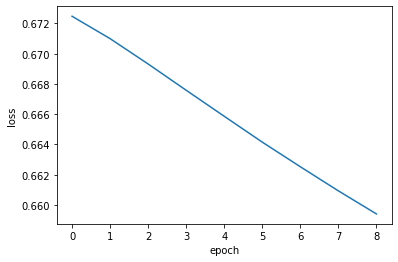

In [36]:
plt.plot(history.history['loss'][1:])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [66]:
def cosine_similarity(a,b):
  
  a = a/np.expand_dims(np.linalg.norm(a,axis=-1),axis=-1)
  b = b/np.expand_dims(np.linalg.norm(b,axis=-1),axis=-1)
  dot_prod = np.sum(a*b,axis=-1)
  

  return dot_prod

In [52]:
def predict(a,b, margin=0):
  
  a = tokenizer.texts_to_sequences(a)
  b = tokenizer.texts_to_sequences(b)
  max_length = np.max((len(a),len(b)))
  max_length = 2**int(np.ceil(np.log2(max_length)))

  predict_input1 = tf.keras.preprocessing.sequence.pad_sequences(a,maxlen=max_length,padding=pad,truncating=pad)
  predict_input2 = tf.keras.preprocessing.sequence.pad_sequences(b,maxlen=max_length,padding=pad,truncating=pad)
  vectors = saimese([predict_input1,predict_input2])
  similarity = cosine_similarity(vectors[0], vectors[1])
 # print(similarity.shape)
  if similarity > 0:
    return 1
  else: 
    return 0

In [53]:
predict("How are you?","How you doing?")
predict("What is your age?","How old are you?")
predict("what is your name?","what is your age?")

(1024,)
(1024,)
()
(1024,)
(1024,)
()
(1024,)
(1024,)
()


1

In [54]:
temp = train_data.head(10).copy()
temp

,id,qid1,qid2,question1,question2,is_duplicate
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
11,11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
12,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
13,13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1
15,15,31,32,What would a Trump presidency mean for current...,How will a Trump presidency affect the student...,1
16,16,33,34,What does manipulation mean?,What does manipulation means?,1
18,18,37,38,Why are so many Quora users posting questions ...,Why do people ask Quora questions which can be...,1
20,20,41,42,Why do rockets look white?,Why are rockets and boosters painted white?,1
29,29,59,60,How should I prepare for CA final law?,How one should know that he/she completely pre...,1


In [81]:

def evaluate(inp):
  inp = inp.dropna()
  y = inp["is_duplicate"].values
  x1 = inp["question1"].values
  x2 = inp["question2"].values

  max_length = 128
  x1 = tokenizer.texts_to_sequences(x1)
  x2 = tokenizer.texts_to_sequences(x2) 

  predict_input1 = tf.keras.preprocessing.sequence.pad_sequences(x1,maxlen=max_length,padding=pad,truncating=pad)
  predict_input2 = tf.keras.preprocessing.sequence.pad_sequences(x2,maxlen=max_length,padding=pad,truncating=pad)

  total = y.shape[0]
  count = 0
  for i in tqdm.tqdm(range(total//256)):

    y_pred_vectors = saimese([predict_input1[i*256:(i+1)*256],predict_input2[i*256:(i+1)*256]])
    y_pred = cosine_similarity(y_pred_vectors[0:256],y_pred_vectors[256:])

    y_pred_actual = 1*(y_pred > 0)
  
    for j in range(256):
      if y[j]==y_pred_actual[j]:
        count+=1

  return count/total


  '''inp["predict"] = inp[["question1","question2"]].progress_apply(lambda x : predict(x["question1"],x["question2"]),axis=1)
  count=np.sum(inp["predict"]==inp["is_duplicate"])
  
  return count/len(inp)'''



In [82]:
full_train_data=pd.read_csv("./data/train.csv")
evaluate(full_train_data)



  0%|          | 0/1579 [00:00<?, ?it/s]

  0%|          | 1/1579 [00:00<12:46,  2.06it/s]

  0%|          | 2/1579 [00:00<12:16,  2.14it/s]

  0%|          | 3/1579 [00:01<11:57,  2.20it/s]

  0%|          | 4/1579 [00:01<11:46,  2.23it/s]

  0%|          | 5/1579 [00:02<11:38,  2.25it/s]

  0%|          | 6/1579 [00:02<11:23,  2.30it/s]

  0%|          | 7/1579 [00:03<11:24,  2.30it/s]

  1%|          | 8/1579 [00:03<11:26,  2.29it/s]

  1%|          | 9/1579 [00:03<11:22,  2.30it/s]

  1%|          | 10/1579 [00:04<11:16,  2.32it/s]

  1%|          | 11/1579 [00:04<11:18,  2.31it/s]

  1%|          | 12/1579 [00:05<11:17,  2.31it/s]

  1%|          | 13/1579 [00:05<11:08,  2.34it/s]

  1%|          | 14/1579 [00:06<11:04,  2.36it/s]

  1%|          | 15/1579 [00:06<11:05,  2.35it/s]

  1%|          | 16/1579 [00:06<11:09,  2.33it/s]

  1%|          | 17/1579 [00:07<11:05,  2.35it/s]

  1%|          | 18/1579 [00:07<11:07,  2.34it/s]

  1%|          | 19/1579 [00:08<11:10,  2.33it/

0.3749415637900798